In [1]:
# %pip install -U lightgbm==3.3.2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [2]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("../src/")
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [3]:
from data import DataHelper
from data.metrics import map_at_k, hr_at_k, recall_at_k

from retrieval.rules import (
    OrderHistory,
    OrderHistoryDecay,
    ItemPair,

    UserGroupTimeHistory,
    UserGroupSaleTrend,

    TimeHistory,
    TimeHistoryDecay,
    SaleTrend,

    OutOfStock,
)
from retrieval.collector import RuleCollector

from features import cum_sale, week_sale, repurchase_ratio, purchased_before

from utils import calc_valid_date, merge_week_data


In [4]:
data_dir = Path("../data/")

In [5]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

In [6]:
TEST = True # * Set as `False` when do local experiments

Pepare data: encoding ids and preprocessing

In [7]:
dh = DataHelper(data_dir)

In [8]:
# data = dh.preprocess_data(save=True, name="encoded_full") # * run only once

In [9]:
data = dh.load_data(name="encoded_full")

In [10]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [12]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)

In [13]:
# * WEEK_NUM = 0: test
# * WEEK_NUM = 1: valid
# * WEEK_NUM > 1: train
for week in range(WEEK_NUM):
    if week == 0 and not TEST:
        continue
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    print(f"Week {week}: [{start_date}, {end_date})")

    train, valid = dh.split_data(trans, start_date, end_date)
    last_week = train.loc[train.t_dat >= last_week_start]
    last_week = last_week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        customer_list=customer_list,
        rules=[
            OrderHistory(train, 7),
            ItemPair(OrderHistory(train, 7).retrieve()),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], 24),
            OrderHistoryDecay(train, 7),
            # OrderHistory(train, 7, n=6),
            # ItemPair(OrderHistory(train, 7, n=6).retrieve()),
            # UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], 24),
            # OrderHistoryDecay(train, 7, n=12),
            # UserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=24),
            # TimeHistory(customer_list, last_week, 7),
            # TimeHistoryDecay(customer_list, train, 7, n=12),
        ],
        filters=[OutOfStock(trans)],
        compress=False,
    )

    scores = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
        .fillna(0)
    )
    hit_rate = (
        pd.pivot_table(
            candidates,
            values="hit_rate",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
        .fillna(0)
    )
    methods = list(candidates['method'].unique())
    scores[methods] = hit_rate[methods] * scores[methods]
    scores['rule_similarity'] = scores[methods].sum(axis=1)
    scores = scores[['customer_id','article_id','rule_similarity']]
    candidates = candidates.merge(scores, on=['customer_id','article_id'], how='left')
    # del candidates['hit_rate']

    # * =========================================================================

    candidates.to_parquet(data_dir/f"interim/week{week}_candidate.pqt")
    if WEEK_NUM != 0:
        valid.to_parquet(data_dir/f"interim/week{week}_label.pqt")

Week 0: [2020-09-23, 2020-09-30)


Retrieve items by rules: 100%|██████████| 4/4 [01:58<00:00, 29.71s/it]


Week 1: [2020-09-16, 2020-09-23)


Retrieve items by rules: 100%|██████████| 4/4 [01:29<00:00, 22.48s/it]


Week 2: [2020-09-09, 2020-09-16)


Retrieve items by rules: 100%|██████████| 4/4 [01:33<00:00, 23.36s/it]


Week 3: [2020-09-02, 2020-09-09)


Retrieve items by rules: 100%|██████████| 4/4 [01:37<00:00, 24.41s/it]


Week 4: [2020-08-26, 2020-09-02)


Retrieve items by rules: 100%|██████████| 4/4 [01:40<00:00, 25.19s/it]


Week 5: [2020-08-19, 2020-08-26)


Retrieve items by rules: 100%|██████████| 4/4 [01:33<00:00, 23.47s/it]


In [14]:
del train, valid, last_week, customer_list, candidates
gc.collect()

21

## Feature engineering


In [14]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [15]:
# merge `product_code`
inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")
# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7

In [16]:
inter = inter.sort_values(["customer_id", "t_dat"]).reset_index(drop=True)

In [17]:
inter.shape

(31788324, 7)

Week Sale

In [18]:
inter["item_sale"] = week_sale(inter, ["article_id"])
inter["pro_sale"] = week_sale(inter, ["product_code"])
inter["item_sale_uni"] = week_sale(inter, ["article_id"], True)
inter["pro_sale_uni"] = week_sale(inter, ["product_code"], True)

inter["item_sale_ratio"] = inter["item_sale"] / (inter["pro_sale"] + 1e-6)
inter["item_sale_uni_ratio"] = inter["pro_sale_uni"] / (inter["pro_sale_uni"] + 1e-6)

item_feats = [
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
]
inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

for feat in tqdm(item_feats):
    inter[f"{feat}_sale"] = week_sale(inter, [feat], f"{feat}_sale")

inter = inter.drop(columns=item_feats)

100%|██████████| 6/6 [00:50<00:00,  8.41s/it]


Repurchase Ratio

In [19]:
inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'])
inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'])

Already Bought Item

In [20]:
inter["purchased_item"] = purchased_before(inter, ["article_id"])
inter["purchased_pro"] = purchased_before(inter, ["product_code"])

Save data

In [21]:
inter.shape

(31788324, 23)

In [22]:
inter.to_parquet(data_dir / "interim/processed_inter.pqt")

## Merge Features


In [15]:
candidates = {}
labels = {}
for i in range(WEEK_NUM):
    if i == 0 and not TEST:
        continue

    tmp_candidate = pd.read_parquet(data_dir / f"interim/week{i}_candidate.pqt")
    candidates[i] = tmp_candidate
    if i == 0:
        labels[i] = None
    else:
        tmp_label = pd.read_parquet(data_dir / f"interim/week{i}_label.pqt")
        labels[i] = tmp_label

In [16]:
inter = pd.read_parquet(data_dir / "interim/processed_inter.pqt")
data["inter"] = inter

Merge features

In [17]:
for i in range(WEEK_NUM):
    if i in candidates:
        candidates[i] = merge_week_data(data, i, candidates[i], labels[i])

100%|██████████| 2030224/2030224 [00:52<00:00, 38385.24it/s]


Merge user and item embeddings

In [18]:
dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)

for i in range(WEEK_NUM):
    if i not in candidates:
        continue
    tmp = candidates[i]
    tmp = tmp.sort_values(by="customer_id").reset_index(drop=True)
    sim = np.zeros(tmp.shape[0])
    cos_sim = np.zeros(tmp.shape[0])
    p = 0
    for uid, chunck in tqdm(tmp.groupby("customer_id")):
        user_embd = dssm_user_embd[uid - 1]
        item_embd = dssm_item_embd[chunck["article_id"].values - 1].T
        
        chunck_sim = user_embd @ item_embd
        # chunck_cos_sim = chunck_sim / (np.linalg.norm(user_embd) * np.linalg.norm(item_embd))
        
        sim[p : p + chunck.shape[0]] = chunck_sim
        # cos_sim[p : p + chunck.shape[0]] = chunck_cos_sim
        p += chunck.shape[0]
    tmp["dssm_similarity"] = sim
    # tmp["dssm_similarity_cos"] = cos_sim
    candidates[i] = tmp

del dssm_user_embd, dssm_item_embd
gc.collect()

100%|██████████| 72035/72035 [00:06<00:00, 10608.92it/s]


9

In [19]:
yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)

for i in range(WEEK_NUM):
    if i not in candidates:
        continue
    tmp = candidates[i]
    tmp = tmp.sort_values(by="customer_id").reset_index(drop=True)
    sim = np.zeros(tmp.shape[0])
    cos_sim = np.zeros(tmp.shape[0])
    p = 0
    for uid, chunck in tqdm(tmp.groupby("customer_id")):
        user_embd = yt_user_embd[uid - 1]
        item_embd = yt_item_embd[chunck["article_id"].values - 1].T
        
        chunck_sim = user_embd @ item_embd
        # chunck_cos_sim = chunck_sim / (np.linalg.norm(user_embd) * np.linalg.norm(item_embd))
        
        sim[p : p + chunck.shape[0]] = chunck_sim
        # cos_sim[p : p + chunck.shape[0]] = chunck_cos_sim
        p += chunck.shape[0]
    tmp["yt_similarity"] = sim
    # tmp["yt_similarity_cos"] = cos_sim
    candidates[i] = tmp

del yt_user_embd, yt_item_embd
gc.collect()

100%|██████████| 72035/72035 [00:06<00:00, 11466.53it/s]


9

Save results

In [20]:
for i in tqdm(candidates.keys()):
    candidates[i].to_parquet(data_dir / f"interim/week{i}_candidate_full.pqt")

100%|██████████| 6/6 [01:03<00:00, 10.51s/it]


## Ranking


In [11]:
candidates = {}
labels = {}
for i in range(WEEK_NUM):
    if i==0 and not TEST:
        continue
    tmp_candidate = pd.read_parquet(data_dir / f"interim/week{i}_candidate_full.pqt")
    tmp_candidate['match_score'] = tmp_candidate['hit_rate'] * tmp_candidate['score']
    candidates[i] = tmp_candidate
    if i != 0:
        tmp_label = pd.read_parquet(data_dir / f"interim/week{i}_label.pqt")
        labels[i] = tmp_label
    else:
        labels[i] = None

In [12]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
        "WeekSaleTrend_item",
        "WeekSaleTrend_pro",
        "ThreeDaySaleTrend_item",
        "ThreeDaySaleTrend_pro",
        "rule_similarity",
        "hit_rate",
        "match_score",
    ]
]
cat_features = [
    "method",  # * retrieval method
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
]


In [13]:
full = [candidates[i] for i in range(WEEK_NUM) if i in candidates]
full = pd.concat(candidates, axis=0).reset_index(drop=True)
full[cat_features] = full[cat_features].astype("category")

for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
    candidates[i] = full[full['week']==i].reset_index(drop=True)

del full
gc.collect()

100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


9

### Train


In [14]:
params = {
    "objective": "lambdarank",
    "boosting_type": "gbdt", # "dart",
    "metric": "map",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.03,

    "verbose": -1,
    "eval_at": 12,
    # 'device':'gpu'
}

In [15]:
train = pd.concat(candidates[i] for i in range(2, WEEK_NUM))
train = train.sort_values(by=['week', 'customer_id'],ascending=True).reset_index(drop=True)

In [16]:
# train['deepfm'] = np.load(data_dir / "external/train_deepfm.npy", allow_pickle=True)

In [17]:
# train_1 = train[train['label']==1]

# train_0 = train[train['label']==0]

# neg_rate = 0.9914394551369939 # 0.98
# neg_num = int(neg_rate * train_1.shape[0] / (1 - neg_rate))
# # train_0 = train_0.sample(neg_num, random_state=42)

# train_0 = train_0.sample(frac=0.9, random_state=42)
# train = pd.concat([train_0, train_1], ignore_index=True)
# train = train.sort_values(by=['week', 'customer_id', 'article_id'],ascending=True).reset_index(drop=True)

In [18]:
sum(train['label']==0) / len(train)

0.991532479002455

In [19]:
valid = candidates[1]
valid = valid.sort_values(by=['customer_id'],ascending=True).reset_index(drop=True)

In [20]:
# valid['deepfm'] = np.load(data_dir / "external/val_deepfm.npy", allow_pickle=True)

In [21]:
train_group = train[["customer_id", "article_id", "week"]]
train_group = train_group.astype("int")
train_group = train_group.groupby(["week","customer_id"])['article_id'].count().values

valid_group = valid[["customer_id", "article_id"]]
valid_group = valid_group.astype("int")
valid_group = valid_group.groupby(["customer_id"])['article_id'].count().values

In [22]:
train_set = lgb.Dataset(
    data=train[feats],
    label=train["label"],
    group=train_group,
    feature_name=feats,
    categorical_feature=cat_features,
    params=params,
)

valid_set = lgb.Dataset(
    data=valid[feats],
    label=valid["label"],
    group=valid_group,
    feature_name=feats,
    categorical_feature=cat_features,
    params=params,
)

ranker = lgb.train(
    params,
    train_set,
    num_boost_round=300,
    valid_sets=[valid_set],
    early_stopping_rounds=50,
    verbose_eval=10
)
# 0.844626
# 0.850902

Training until validation scores don't improve for 50 rounds
[10]	valid_0's map@12: 0.842359
[20]	valid_0's map@12: 0.843082
[30]	valid_0's map@12: 0.843286
[40]	valid_0's map@12: 0.843942
[50]	valid_0's map@12: 0.844322
[60]	valid_0's map@12: 0.844645
[70]	valid_0's map@12: 0.84495
[80]	valid_0's map@12: 0.845265
[90]	valid_0's map@12: 0.845744
[100]	valid_0's map@12: 0.845759
[110]	valid_0's map@12: 0.845772
[120]	valid_0's map@12: 0.845793
[130]	valid_0's map@12: 0.845867
[140]	valid_0's map@12: 0.845909
[150]	valid_0's map@12: 0.84583
[160]	valid_0's map@12: 0.84589
[170]	valid_0's map@12: 0.845915
[180]	valid_0's map@12: 0.84593
[190]	valid_0's map@12: 0.845942
[200]	valid_0's map@12: 0.845928
[210]	valid_0's map@12: 0.845975
[220]	valid_0's map@12: 0.845993
[230]	valid_0's map@12: 0.845917
[240]	valid_0's map@12: 0.845973
[250]	valid_0's map@12: 0.845926
[260]	valid_0's map@12: 0.845941
Early stopping, best iteration is:
[216]	valid_0's map@12: 0.846007


In [23]:
ranker.save_model(data_dir / "interim/lgb_ranker.model", num_iteration=ranker.best_iteration)

### Inference

In [24]:
ranker = lgb.Booster(model_file=data_dir / "interim/lgb_ranker.model")

<Figure size 576x864 with 0 Axes>

<AxesSubplot:xlabel='importance', ylabel='feature'>

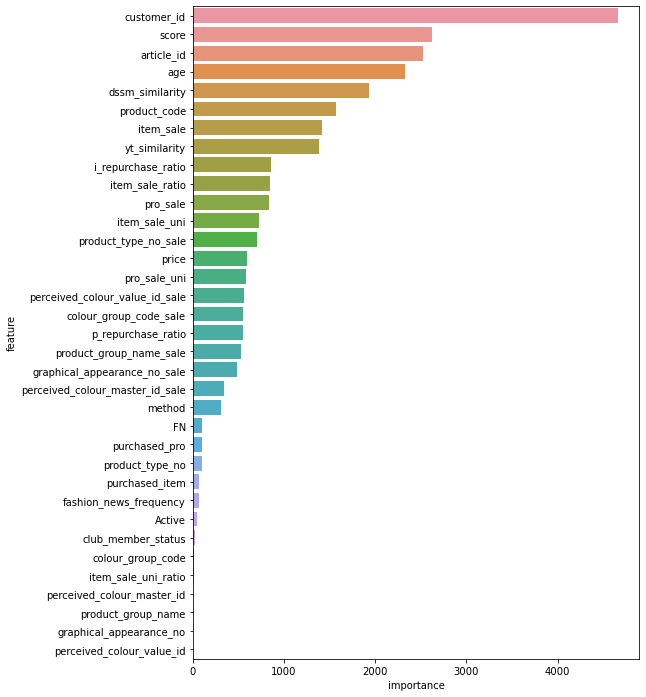

In [25]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 12))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Validate

In [26]:
val_candidates = candidates[1].reset_index(drop=True)

In [27]:
probs = np.zeros(val_candidates.shape[0])
batch_size = 5_000_000
for batch in tqdm(range(0, val_candidates.shape[0], batch_size)):
    outputs = ranker.predict(val_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs

100%|██████████| 1/1 [00:16<00:00, 16.95s/it]


In [28]:
val_candidates["prob"] = probs

In [29]:
pred_lgb = val_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)

In [30]:
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')

In [31]:
pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()

100%|██████████| 1371980/1371980 [01:55<00:00, 11831.71it/s]


In [32]:
label = labels[1]
label = pd.merge(label, pred_lgb, on="customer_id", how="left")

In [33]:
map_at_k(label["article_id"], label["prediction"], k=12)

# 0.02820525160663368 1-week add normalization
# 0.028696340326235064 4-week

0.028696340326235064

### Test

In [34]:
test_candidates = candidates[0].reset_index(drop=True)

In [35]:
probs = np.zeros(test_candidates.shape[0])
batch_size = 5_000_000
for batch in tqdm(range(0, test_candidates.shape[0], batch_size)):
    outputs = ranker.predict(test_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs

100%|██████████| 9/9 [04:56<00:00, 32.95s/it]


In [36]:
test_candidates["prob"] = probs

In [37]:
pred_lgb = test_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)

In [38]:
idx2uid = pickle.load(open(data_dir/"index_id_map/user_index2id.pkl", "rb"))
idx2iid = pickle.load(open(data_dir/"index_id_map/item_index2id.pkl", "rb"))

In [39]:
pred_lgb['prediction'] = pred_lgb['prediction'].map(idx2iid).progress_apply(lambda x:'0'+str(x))
pred_lgb = pred_lgb.groupby('customer_id')['prediction'].progress_apply(list).reset_index()
pred_lgb['prediction'] = pred_lgb['prediction'].progress_apply(lambda x: ' '.join(x[:12]))

100%|██████████| 1371980/1371980 [00:01<00:00, 704548.83it/s]


In [40]:
del submission['prediction']
submission = submission.merge(pred_lgb, on='customer_id', how='left')
submission['customer_id'] = submission['customer_id'].map(idx2uid)

In [41]:
submission.to_csv('submission.csv', index=False)

In [42]:
submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006 0918522001 0779781015 0568601043 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0918522001 0915526001 0866731001 0918292001 04...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0794321007 0918522001 0866731001 04...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0918522001 0751471043 0751471001 0915529003 08...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0896152002 0896152001 0927530006 09...
